In [1]:
import numpy as np
import pandas as pd

In [2]:
access = pd.read_csv('LP_Access.csv')

In [3]:
access['Start Time (UTCG)'] = pd.to_datetime(access['Start Time (UTCG)'])
access['Stop Time (UTCG)'] = pd.to_datetime(access['Stop Time (UTCG)'])

# time resolution
slot_length = 300  # seconds (1-minute slots)

# full time range
start_time = access['Start Time (UTCG)'].min().floor('min')
end_time = access['Stop Time (UTCG)'].max().ceil('min')

# generate list of time slot start times
time_index = pd.date_range(start=start_time, end=end_time, freq=f'{slot_length}S')
num_slots = len(time_index)

# map each timestamp to a column index
time_to_index = pd.Series(index=time_index, data=np.arange(num_slots))

# get unique satellites
sat_ids = access['Satellite'].unique()
sat_ids.sort()
sat_index = {sat: i for i, sat in enumerate(sat_ids)}
num_sats = len(sat_ids)

# initialize A (access window matrix)
A = np.zeros((num_sats, num_slots), dtype=int)

# Populate A
for _, row in access.iterrows():
    sat = row['Satellite']
    start = row['Start Time (UTCG)']
    stop = row['Stop Time (UTCG)']

    # clip to exact indices
    start_idx = int(((start - start_time).total_seconds()) // slot_length)
    stop_idx = int(np.ceil((stop - start_time).total_seconds() / slot_length))
    
    A[sat_index[sat], start_idx:stop_idx] = 1

C:\Users\rswil\AppData\Local\Temp\ipykernel_16064\1985450645.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  access['Start Time (UTCG)'] = pd.to_datetime(access['Start Time (UTCG)'])
C:\Users\rswil\AppData\Local\Temp\ipykernel_16064\1985450645.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  access['Stop Time (UTCG)'] = pd.to_datetime(access['Stop Time (UTCG)'])


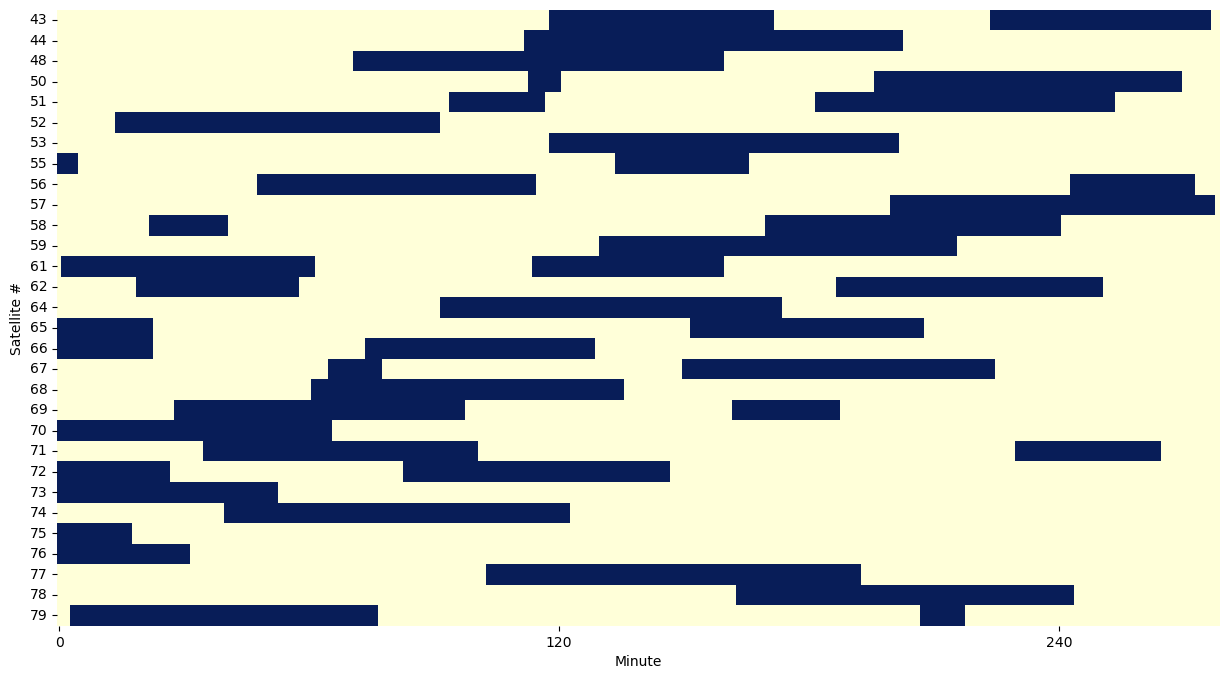

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.heatmap(A, cmap="YlGnBu", cbar=False, xticklabels=120)  # show label every 120 minutes

plt.xlabel("Minute")
plt.ylabel("Satellite #")

# Set y-axis tick labels to Satellite numbers
plt.yticks(ticks=np.arange(len(sat_ids)) + 0.5, labels=sat_ids, rotation=0)
plt.show()

In [5]:
n = num_sats              # nnmber of satellites
T = num_slots             # number of time slots (minutes in a day)

total_access = access.groupby('Satellite')['Duration (sec)'].sum()
priority_scores = total_access.max() / total_access
P = np.array(priority_scores)   # priority for each satellite
# Define access time requirements based on satellite number
m = np.zeros(n, dtype=int)  # min access
M = np.zeros(n, dtype=int)  # max access (hard limit)

for i, sat in enumerate(sat_ids):
    if 43 <= sat <= 61:
        m[i] = 35
        M[i] = 65
    elif 62 <= sat <= 73:
        m[i] = 50
        M[i] = 80
    elif sat >= 74:
        m[i] = 75
        M[i] = 105

# M = np.sum(A, axis=1)
m = m // 5
M = M // 5

'''
T/n = 110 (average of 110 minutes available per satellite)
avg(P) = 3 (average priority score of 3)
So, the average objective value for the priority score is 110*3. I've chosen alpha=330 as well.
That way, the # of satellites accessed and priority score are equally weighted.
'''
alpha = 110

In [6]:
from pulp import LpVariable, LpBinary, LpContinuous, LpMaximize, LpProblem, lpSum, GLPK_CMD

# create the optimization problem
prob = LpProblem("Satellite_Access_Scheduling", LpMaximize)

# decision variables
x = [[LpVariable(f"x_{i}_{j}", lowBound=0, upBound=1, cat=LpContinuous)
      for j in range(T)] for i in range(n)]

y = [LpVariable(f"y_{i}", cat=LpBinary) for i in range(n)]  # 1 if satellite i is accessed at all

# maximize total priority-weighted access
prob += lpSum(P[i] * x[i][j] for i in range(n) for j in range(T)) + alpha * lpSum(y[i] for i in range(n))

# only access when available
for i in range(n):
    for j in range(T):
        prob += x[i][j] <= A[i][j]

# only one satellite accessed at a time
for j in range(T):
    prob += lpSum(x[i][j] for i in range(n)) <= 1

# minimum access time if selected
for i in range(n):
    prob += lpSum(x[i][j] for j in range(T)) >= m[i] * y[i]

for i in range(n):
    prob += lpSum(x[i][j] for j in range(T)) <= M[i] * y[i]

B = 24  # 2-hour break
break_starts = [k for k in range(0, T - B + 1) if k % 60 in [0, 3, 6, 9]]  # 15 min
b = [LpVariable(f"break_{k}", cat=LpBinary) for k in break_starts]

# Only one break window allowed
prob += lpSum(b) == 1

# Enforce zero access during the selected break
for k_idx, k in enumerate(break_starts):
    for i in range(n):
        prob += lpSum(x[i][j] for j in range(k, k + B)) <= (1 - b[k_idx]) * B

# solve
prob.solve(GLPK_CMD(msg=True))
    
# results
from pulp import LpStatus, value

print("Status:", LpStatus[prob.status])
print("Total Priority Access Value:", value(prob.objective))
total_time = 0
for i in range(n):
    total_access = sum(x[i][j].varValue for j in range(T)) * 5  # convert to minutes
    total_time += total_access
    svn = sat_ids[i]  # get the real SVN
    print(f"Satellite SVN {svn}: y = {y[i].varValue}, total access = {total_access:.2f} minutes")
print("Total Time Accessing Satellites:", total_time, "minutes")

Status: Optimal
Total Priority Access Value: 3275.943569246178
Satellite SVN 43: y = 1, total access = 35.00 minutes
Satellite SVN 44: y = 1, total access = 35.00 minutes
Satellite SVN 48: y = 1, total access = 35.00 minutes
Satellite SVN 50: y = 1, total access = 35.00 minutes
Satellite SVN 51: y = 1, total access = 35.00 minutes
Satellite SVN 52: y = 1, total access = 35.00 minutes
Satellite SVN 53: y = 1, total access = 35.00 minutes
Satellite SVN 55: y = 1, total access = 35.00 minutes
Satellite SVN 56: y = 1, total access = 35.00 minutes
Satellite SVN 57: y = 1, total access = 35.00 minutes
Satellite SVN 58: y = 1, total access = 35.00 minutes
Satellite SVN 59: y = 1, total access = 35.00 minutes
Satellite SVN 61: y = 1, total access = 35.00 minutes
Satellite SVN 62: y = 1, total access = 50.00 minutes
Satellite SVN 64: y = 1, total access = 50.00 minutes
Satellite SVN 65: y = 0, total access = 0.00 minutes
Satellite SVN 66: y = 1, total access = 50.00 minutes
Satellite SVN 67: y 

In [8]:
access_matrix = np.array([[x[i][j].varValue for j in range(T)] for i in range(n)])

In [ ]:
# Identify and print the selected break window start
for k_idx, k in enumerate(break_starts):
    if b[k_idx].varValue == 1:
        print(f"Break starts at time slot {k} which corresponds to {time_index[k]}")
        break

Break starts at time slot 129 (index in A), which corresponds to 2025-06-24 10:45:00


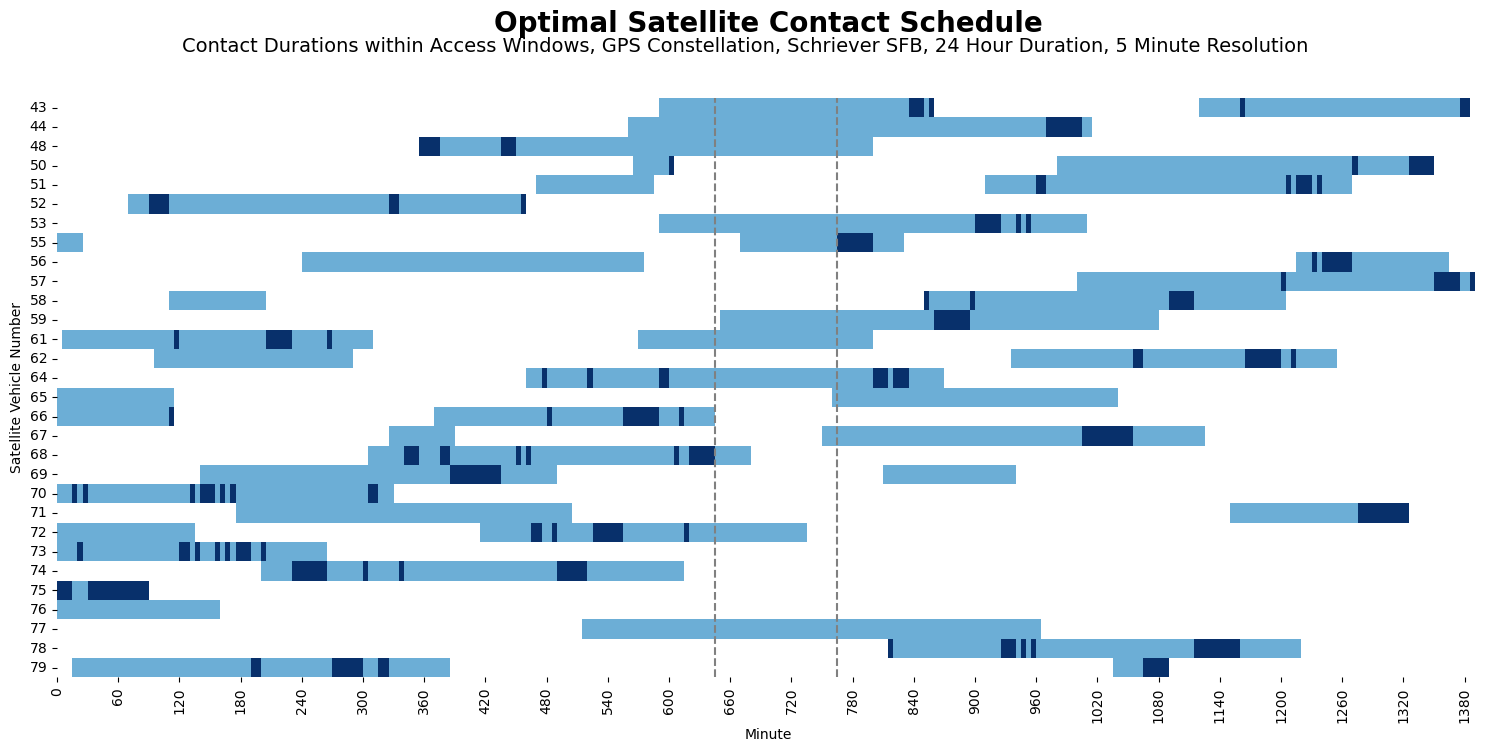

In [10]:
plt.figure(figsize=(15, 8))

# Set custom colormap: white for 0, orange gradient otherwise
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['white'] + sns.color_palette("Blues", n_colors=256).as_hex())

ax = sns.heatmap(access_matrix + A, cmap=cmap, cbar=False)

# Vertical lines for marking events
ax.axvline(129, linestyle='--', color='gray')
ax.axvline(129 + 24, linestyle='--', color='gray')

# X-axis ticks and labels
ax.set_xticks(np.arange(0, A.shape[1], 12))  # every 12th 5-minute slot (i.e., every hour)
ax.set_xticklabels([str(i * 5) for i in range(0, A.shape[1], 12)])  # show minutes

# Y-axis labels (satellite numbers)
plt.yticks(ticks=np.arange(len(sat_ids)) + 0.5, labels=sat_ids, rotation=0)

# Axis labels
plt.xlabel("Minute")
plt.ylabel("Satellite Vehicle Number")

# Add title and subtitle
plt.title("Optimal Satellite Contact Schedule", fontsize=20, weight='bold', y=1.10)
plt.suptitle("Contact Durations within Access Windows, GPS Constellation, Schriever SFB, 24 Hour Duration, 5 Minute Resolution", fontsize=14, y=0.90)

plt.tight_layout()
plt.show()

In [ ]:
alphas = range(0, 61, 5)
results = []

priority_expr = lpSum(P[i] * x[i][j] for i in range(n) for j in range(T))
satellite_count_expr = lpSum(y[i] for i in range(n))

for alpha_val in alphas:
    prob.setObjective(priority_expr + alpha_val * satellite_count_expr)
    prob.solve(GLPK_CMD(msg=False))

    y_vals = [y[i].varValue for i in range(n)]
    x_vals = [[x[i][j].varValue for j in range(T)] for i in range(n)]

    results.append({
        "alpha": alpha_val,
        "status": LpStatus[prob.status],
        "objective": value(prob.objective),
        "num_satellites": sum(y_vals),
        "priority_score": sum(P[i] * sum(x_vals[i]) for i in range(n))
    })

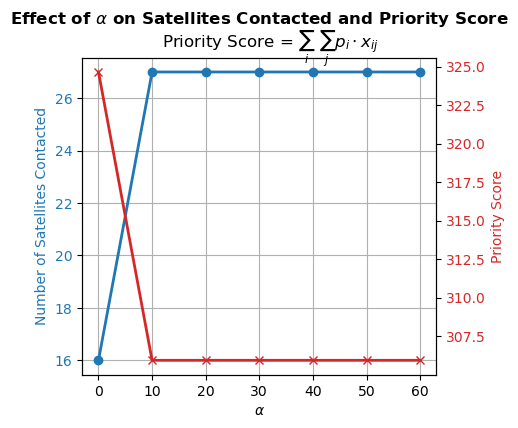

In [35]:
fig, ax1 = plt.subplots(figsize=(5, 5))

# Primary y-axis: number of satellites contacted
ax1.plot(
    [r["alpha"] for r in results],
    [r["num_satellites"] for r in results],
    marker='o', color='tab:blue', label="Satellites Contacted",
    linewidth=2
)
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel("Number of Satellites Contacted", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Secondary y-axis: priority score
ax2 = ax1.twinx()
ax2.plot(
    [r["alpha"] for r in results],
    [r["priority_score"] for r in results],
    marker='x', color='tab:red', label="Priority Score",
    linewidth=2
)
ax2.set_ylabel("Priority Score", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout
plt.title(r"Effect of $\alpha$ on Satellites Contacted and Priority Score", weight='bold', y=1.08)
plt.suptitle(r"Priority Score = $\sum_{i}  \ \sum_j p_i \cdot x_{ij}$", y=0.81)
fig.tight_layout()
plt.show()